# 🌡️ Global Land Temperature Prediction Project
**Makine Öğrenmesi Bootcamp Projesi**

Bu projede, GlobalLandTemperaturesByCountry veri setini kullanarak ülkelere ait geçmiş sıcaklık verilerinden yola çıkarak gelecekteki sıcaklıkları tahmin eden bir model geliştireceğiz.

## 1. Kütüphanelerin Yüklenmesi

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## 2. Veri Setinin Yüklenmesi

In [134]:
# Dataset: https://www.kaggle.com/datasets/subhamjain/temperature-of-all-countries-19952020
df = pd.read_csv("GlobalLandTemperaturesByCountry.csv")
print(df)
df.head()

                Region  Country                   State                  City  \
0               Africa  Algeria                     NaN               Algiers   
1               Africa  Algeria                     NaN               Algiers   
2               Africa  Algeria                     NaN               Algiers   
3               Africa  Algeria                     NaN               Algiers   
4               Africa  Algeria                     NaN               Algiers   
...                ...      ...                     ...                   ...   
2906322  North America       US  Additional Territories  San Juan Puerto Rico   
2906323  North America       US  Additional Territories  San Juan Puerto Rico   
2906324  North America       US  Additional Territories  San Juan Puerto Rico   
2906325  North America       US  Additional Territories  San Juan Puerto Rico   
2906326  North America       US  Additional Territories  San Juan Puerto Rico   

         Month  Day  Year  

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


## 3. Keşifsel Veri Analizi (EDA)

In [137]:
# Genel bilgi
print(df.info())

# Eksik veriler
print(df.isnull().sum())

# Bazı istatistikler
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB
None
Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64
              Month           Day          Year  AvgTemperature
count  2.906327e+06  2.906327e+06  2.906327e+06    2.906327e+06
mean   6.469163e+00  1.571682e+01  2.006624e+03    5.600492e+01
std    3.456489e+00  8.800534e+00  2.338226e+01    3.212359e+01
min    1.000000e+00  0.000000e+00  2.000000e+02   -9

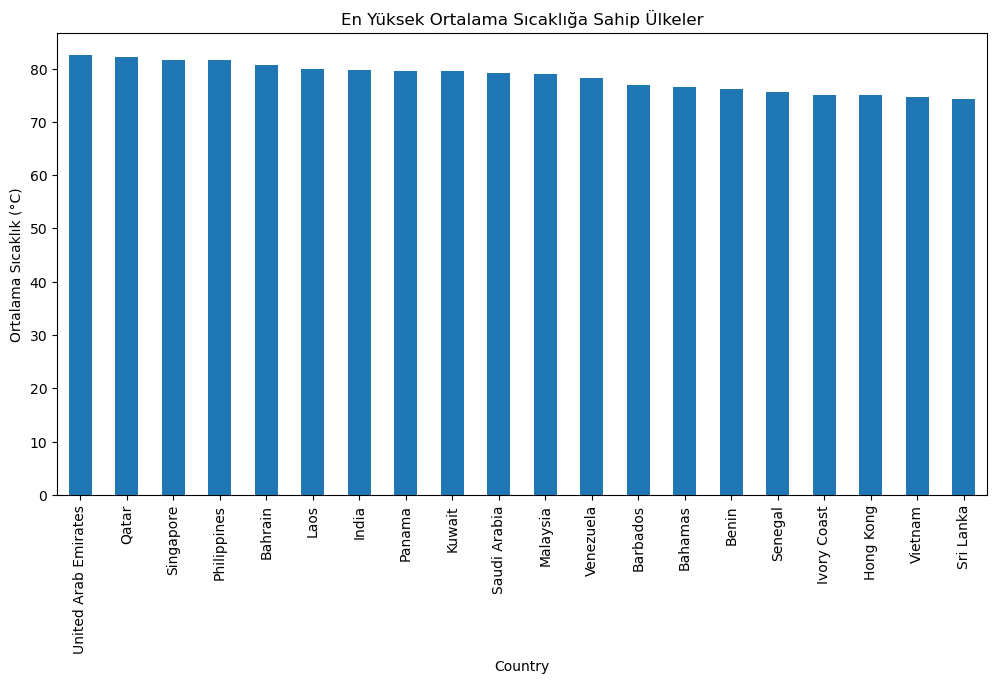

In [139]:
# Ülke bazlı ortalama sıcaklık
country_avg = df.groupby('Country')['AvgTemperature'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
country_avg[:20].plot(kind='bar')
plt.title('En Yüksek Ortalama Sıcaklığa Sahip Ülkeler')
plt.ylabel('Ortalama Sıcaklık (°C)')
plt.show()

In [141]:
print(df['AvgTemperature'].describe())
print(df['AvgTemperature'].value_counts().sort_index())

count    2.906327e+06
mean     5.600492e+01
std      3.212359e+01
min     -9.900000e+01
25%      4.580000e+01
50%      6.250000e+01
75%      7.550000e+01
max      1.100000e+02
Name: AvgTemperature, dtype: float64
AvgTemperature
-99.0     79672
-50.0         1
-49.1         1
-47.7         1
-46.9         1
          ...  
 109.5        1
 109.7        1
 109.8        1
 109.9        4
 110.0        1
Name: count, Length: 1517, dtype: int64


Aşırı sapan değerlerle karşılaştık bu değerlerin veri setinden temizlenmesini sağlayarak doğru sonuç alacağız.

## 4. Veri Ön İşleme

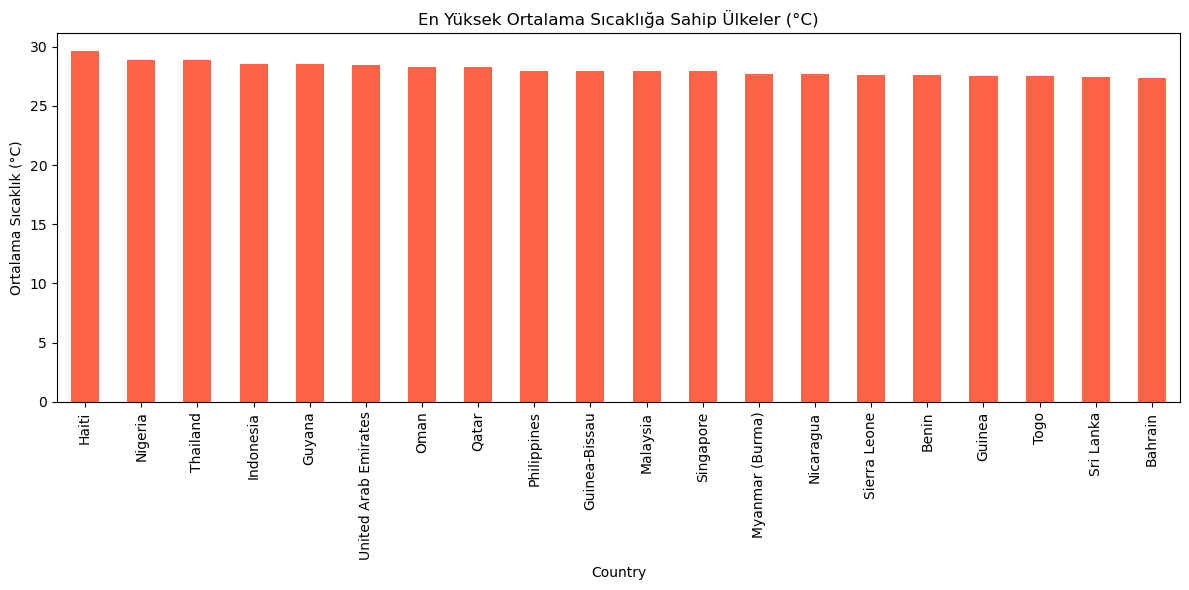

In [145]:
# Eksik veri placeholder'ı olan kaldır
df = df[df['AvgTemperature'] != -99.0]

# Fahrenheit'tan Celsius'a dönüştür
df['AvgTemperature_C'] = (df['AvgTemperature'] - 32) * 5 / 9

# Ülke bazında ortalama sıcaklığı hesapla
country_avg = df.groupby('Country')['AvgTemperature_C'].mean().sort_values(ascending=False)

# İlk 20 ülkeyi bar grafiğiyle göster
plt.figure(figsize=(12,6))
country_avg.head(20).plot(kind='bar', color='tomato')
plt.title('En Yüksek Ortalama Sıcaklığa Sahip Ülkeler (°C)')
plt.ylabel('Ortalama Sıcaklık (°C)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [147]:
print(df)

                Region  Country                   State                  City  \
0               Africa  Algeria                     NaN               Algiers   
1               Africa  Algeria                     NaN               Algiers   
2               Africa  Algeria                     NaN               Algiers   
3               Africa  Algeria                     NaN               Algiers   
4               Africa  Algeria                     NaN               Algiers   
...                ...      ...                     ...                   ...   
2906322  North America       US  Additional Territories  San Juan Puerto Rico   
2906323  North America       US  Additional Territories  San Juan Puerto Rico   
2906324  North America       US  Additional Territories  San Juan Puerto Rico   
2906325  North America       US  Additional Territories  San Juan Puerto Rico   
2906326  North America       US  Additional Territories  San Juan Puerto Rico   

         Month  Day  Year  

In [151]:
# Ülke isimlerini kodlayalım
le = LabelEncoder()
df['CountryEncoded'] = le.fit_transform(df['Country'])

In [155]:
print(features.isnull().sum())
print(target.isnull().sum())
print(df)

Year              0
Month             0
CountryEncoded    0
dtype: int64
0
                Region  Country                   State                  City  \
0               Africa  Algeria                     NaN               Algiers   
1               Africa  Algeria                     NaN               Algiers   
2               Africa  Algeria                     NaN               Algiers   
3               Africa  Algeria                     NaN               Algiers   
4               Africa  Algeria                     NaN               Algiers   
...                ...      ...                     ...                   ...   
2906322  North America       US  Additional Territories  San Juan Puerto Rico   
2906323  North America       US  Additional Territories  San Juan Puerto Rico   
2906324  North America       US  Additional Territories  San Juan Puerto Rico   
2906325  North America       US  Additional Territories  San Juan Puerto Rico   
2906326  North America       US  A

In [157]:
# Özellik ve hedef değişkenler
features = df[['Year', 'Month', 'CountryEncoded']]
target = df['AvgTemperature']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## 5. Modelleme ve Hiperparametre Optimizasyonu

In [160]:
# Random Forest modeli ve Grid Search ile hiperparametre ayarı
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print('En iyi parametreler:', grid_search.best_params_)

En iyi parametreler: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


## 6. Model Değerlendirme

In [162]:
y_pred = best_model.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2 Skoru:', r2_score(y_test, y_pred))

MAE: 7.126032364815603
MSE: 97.22409660353833
R2 Skoru: 0.7312017791376129


### 📈 Model Performans Değerlendirmesi

Modelin test verisi üzerindeki performansını değerlendirmek için üç temel regresyon metriği kullanılmıştır: MAE, MSE ve R² skoru.

- **MAE (Mean Absolute Error): 7.13**

  Ortalama mutlak hata, modelin tahminlerinin gerçek sıcaklık değerlerinden ortalama olarak ne kadar saptığını gösterir. 7.13’lük bir MAE değeri, modelin sıcaklık tahminlerinde yaklaşık 7°F’lik bir ortalama hata ile çalıştığını ortaya koyar. Bu seviye, sıcaklık gibi doğal dalgalanmalara açık bir veri seti için makul kabul edilebilir.

- **MSE (Mean Squared Error): 97.22**

  Ortalama karesel hata, büyük sapmalara daha fazla ceza veren bir metriktir. Bu değerin biraz yüksek olması, bazı uç tahmin hatalarının modelde yer aldığını gösterebilir. Ancak genel hataların büyüklüğünü anlamak için MAE ile birlikte değerlendirilmesi daha sağlıklı olur.

- **R² Skoru: 0.731**

  Determinasyon katsayısı, modelin bağımlı değişkendeki (sıcaklık) değişkenliğin ne kadarını açıkladığını gösterir. 0.731’lik R² skoru, modelin sıcaklık verilerindeki varyansın yaklaşık %73’ünü başarılı şekilde açıkladığını gösterir. Bu, istatistiksel olarak orta-iyi düzeyde bir performanstır ve modelin genel yapıyı yakalayabildiğini ifade eder.

#### 🧾 Genel Yorum:

Model, sıcaklık tahminleri konusunda genel olarak başarılı sonuçlar vermektedir. Ortalama hata seviyeleri makul, varyans açıklama oranı ise tatmin edicidir. Ancak daha yüksek doğruluk için:

- Yeni öznitelikler eklenmesi (örneğin mevsimsel etki, coğrafi koordinatlar),
- Aykırı değerlerin daha kapsamlı temizlenmesi,
- Hiperparametre optimizasyonunun derinleştirilmesi gibi adımlar faydalı olabilir.

Bu sonuçlar, modelin birçok pratik uygulama için kullanılabilir düzeyde olduğunu ve daha iyi sonuçlar için geliştirilmeye açık olduğunu göstermektedir.
